In [25]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
from tqdm import tqdm

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


In [26]:
class KNearestNeighbor(object):
    def __init__(self):
        pass
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)


    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 
        dists = np.sqrt(np.sum(np.square(self.X_train), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.X_train.T))
        pass
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in tqdm(range(num_test)):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.y_train[sorted_dist[0:k]])
            pass
            y_pred[i]= (np.argmax(np.bincount(closest_y)))
            pass
        return y_pred



# Loading raw files and  training datasets

In [27]:
cifar10_dir = 'datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


# Visual representation of samples

10it [00:01,  6.84it/s]


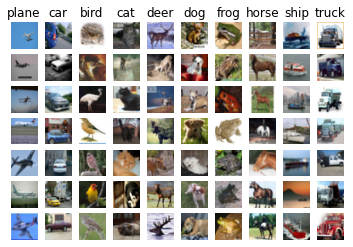

In [28]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in tqdm(enumerate(classes)):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# subsampling

In [29]:
# Memory error prevention by subsampling data

num_training = 10000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 1000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [30]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)


(10000, 3072) (1000, 3072)


# Performing K-NN

In [31]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists= classifier.compute_distances(X_test)
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1549.61it/s]

Got 296 / 1000 correct => accuracy: 0.296000


In [32]:
(train_imgs, train_labels),(test_imgs, test_labels)= tf.keras.datasets.cifar10.load_data()

# UTILITY FUNCTIONS

In [33]:
def getL2DistanceMatrix(train,test):
  num_test = test.shape[0]
  num_train = train.shape[0]
  L2_dists = np.zeros((num_test, num_train))
  # L1_dists = np.zeros((num_test, num_train))
  for i in range(num_test):
    # L1_dists[i, :] = np.sum(np.square(X_test[i] - X_train), axis=1)
    L2_dists[i, :] = np.sqrt(np.sum(np.square(X_test[i] - X_train), axis=1))
  return L2_dists

def predict(distance, k=1):
  num_test = distance.shape
  y_pred = np.zeros(num_test)
  for i in range(num_test):
    closest_y = []
    closest_y = np.take(y_train, np.argsort(distance[i]))[:k]
    (values, counts) = np.unique(closest_y, return_counts=True)
    y_pred[i] = values[np.argmax(counts)]

    return y_pred

# L1 & L2 Distance Matrix

In [34]:
X_train = train_imgs
y_train = train_labels[:,0]
X_test = test_imgs
y_test = test_labels[:,0]

num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

num_test = X_test.shape[0]
num_train = X_train.shape[0]
L2_dists = np.zeros((num_test, num_train))
L1_dists = np.zeros((num_test, num_train))
for i in range(num_test):
    L1_dists[i, :] = np.sum(np.square(X_test[i] - X_train), axis=1)
    L2_dists[i, :] = np.sqrt(np.sum(np.square(X_test[i] - X_train), axis=1))

print("L1 Matrix : ",L1_dists)
print("L2 Matrix : ",L2_dists)


(5000, 3072) (500, 3072)
L1 Matrix :  [[320202. 322911. 329559. ... 318775. 328690. 326376.]
 [323653. 328556. 345940. ... 321170. 332665. 330365.]
 [324224. 322045. 327531. ... 323683. 318426. 319236.]
 ...
 [335259. 322262. 320402. ... 325350. 326027. 326029.]
 [321336. 323477. 317605. ... 334015. 324710. 323762.]
 [319813. 315252. 327596. ... 328426. 330491. 332633.]]
L2 Matrix :  [[565.86394124 568.25258468 574.0722951  ... 564.60162947 573.31492219
  571.2932697 ]
 [568.90508875 573.19804605 588.16664305 ... 566.71862507 576.77118513
  574.77386858]
 [569.40670878 567.49008802 572.3032413  ... 568.93145457 564.29247736
  565.00973443]
 ...
 [579.01554383 567.68124859 566.04063458 ... 570.39460025 570.98774067
  570.98949202]
 [566.86506331 568.75038462 563.56454821 ... 577.94030834 569.83330896
  569.00087873]
 [565.52011458 561.47306258 572.36002656 ... 573.08463598 574.88346645
  576.74344383]]


# Cross validation

performing 5-fold cross validation on k-NN for varying values of k 

In [38]:
num_folds = 5
k_choices = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
k_to_accuracies = {}



for k in tqdm(k_choices):
    k_to_accuracies[k] = []
    for num_knn in range(0,num_folds):
        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds
        
        temp = np.delete(X_train,num_knn,0)
        X_train = np.concatenate((temp),axis = 0)
        y_train = np.delete(y_train,num_knn,0)
        y_train = np.concatenate((y_train),axis = 0)
        
        classifier = KNearestNeighbor()
        classifier.train(X_train, y_train)
        dists = classifier.compute_distances(X_test)
        y_test_pred = classifier.predict_labels(dists, k)

        num_correct = np.sum(y_test_pred == y_test)
        accuracy = float(num_correct) / num_test
#         print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[k].append(accuracy)


print("Printing our 5-fold accuracies for varying values of k:")
print()
for k in tqdm(sorted(k_to_accuracies)):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5198.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5445.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 4728.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 4875.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5427.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 4943.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5286.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5262.53it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5194.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5386.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5101.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5590.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5000.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5337.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5739.10it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5391.14it/s]

100%|███████████████████████████

Printing our 5-fold accuracies for varying values of k:



100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 10024.63it/s]

k = 1, accuracy = 0.148000
k = 1, accuracy = 0.168000
k = 1, accuracy = 0.180000
k = 1, accuracy = 0.178000
k = 1, accuracy = 0.166000
k = 2, accuracy = 0.148000
k = 2, accuracy = 0.168000
k = 2, accuracy = 0.180000
k = 2, accuracy = 0.178000
k = 2, accuracy = 0.166000
k = 3, accuracy = 0.148000
k = 3, accuracy = 0.168000
k = 3, accuracy = 0.180000
k = 3, accuracy = 0.178000
k = 3, accuracy = 0.166000
k = 4, accuracy = 0.148000
k = 4, accuracy = 0.168000
k = 4, accuracy = 0.180000
k = 4, accuracy = 0.178000
k = 4, accuracy = 0.166000
k = 5, accuracy = 0.148000
k = 5, accuracy = 0.168000
k = 5, accuracy = 0.180000
k = 5, accuracy = 0.166000
k = 5, accuracy = 0.166000
k = 6, accuracy = 0.148000
k = 6, accuracy = 0.168000
k = 6, accuracy = 0.180000
k = 6, accuracy = 0.178000
k = 6, accuracy = 0.166000
k = 7, accuracy = 0.148000
k = 7, accuracy = 0.168000
k = 7, accuracy = 0.180000
k = 7, accuracy = 0.178000
k = 7, accuracy = 0.166000
k = 8, accuracy = 0.148000
k = 8, accuracy = 0.168000
k

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 364.51it/s]


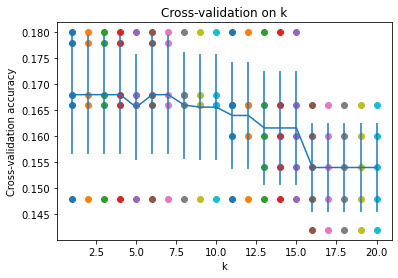

In [39]:
for k in tqdm(k_choices):
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [40]:
# Choosing best value of k based on cross-validation results

best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Computing and displaying the accuracy for best k found during cross-validation
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

100%|██████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 5014.18it/s]

Got 83 / 500 correct => accuracy: 0.166000
